<a href="https://colab.research.google.com/github/shreyashrivastava1/BrainTumorClassification/blob/main/Custom_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import itertools
!pip install opendatasets
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')


In [11]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c/data")


Skipping, found downloaded files in "./brain-tumor-mri-images-44c" (use force=True to force download)


In [12]:
data_dir = '/content/brain-tumor-mri-images-44c'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    print(fold)
    foldpath = os.path.join(data_dir, fold)
    print(foldpath)
    filelist = os.listdir(foldpath)
    print(filelist)

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        # print(fpath)
        filepaths.append(fpath)
        labels.append(fold)


FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)
display(df)

Meningioma T1C+
/content/brain-tumor-mri-images-44c/Meningioma T1C+
['2022-05-30 15_23_42-Meningioma _ Radiology Case _ Radiopaedia.org - Opera.jpg', '3fa6c1b0123f0c619c498776e7f653_big_gallery.jpg', '23f0f67e7ec57580f5131970bdc3d8_big_gallery.jpeg', '2022-05-28 10_58_21-Meningioma _ Radiology Case _ Radiopaedia.org - Opera.jpg', '86626911785108ccb63d6ddf5b6f7b_big_gallery.jpeg', '2022-05-30 15_20_51-Angiomatous meningioma _ Radiology Case _ Radiopaedia.org - Opera.jpg', '2022-05-30 15_20_59-Angiomatous meningioma _ Radiology Case _ Radiopaedia.org - Opera.jpg', '2022-05-30 15_18_02-Meningothelial meningioma _ Radiology Case _ Radiopaedia.org - Opera.jpg', 'faba0f299216204cb70826d1cee5bc_big_gallery.jpeg', '2022-05-30 15_21_08-Angiomatous meningioma _ Radiology Case _ Radiopaedia.org - Opera.jpg', '172f421c2ca32f24e9fe158f34616b_big_gallery.jpeg', '7d9b971db8922a56ce01b9e14c95bc_big_gallery.jpeg', '2022-05-30 16_48_38-Angiomatous meningioma _ Radiology Case _ Radiopaedia.org - Opera.jp

,filepaths,labels
0,/content/brain-tumor-mri-images-44c/Meningioma...,Meningioma T1C+
1,/content/brain-tumor-mri-images-44c/Meningioma...,Meningioma T1C+
2,/content/brain-tumor-mri-images-44c/Meningioma...,Meningioma T1C+
3,/content/brain-tumor-mri-images-44c/Meningioma...,Meningioma T1C+
4,/content/brain-tumor-mri-images-44c/Meningioma...,Meningioma T1C+
...,...,...
4474,/content/brain-tumor-mri-images-44c/Astrocitom...,Astrocitoma T1
4475,/content/brain-tumor-mri-images-44c/Astrocitom...,Astrocitoma T1
4476,/content/brain-tumor-mri-images-44c/Astrocitom...,Astrocitoma T1
4477,/content/brain-tumor-mri-images-44c/Astrocitom...,Astrocitoma T1


In [13]:
df['labels'].value_counts()

,count
labels,
Meningioma T1C+,369
Meningioma T1,272
_NORMAL T2,271
_NORMAL T1,251
Astrocitoma T1C+,233
Meningioma T2,233
Neurocitoma T1C+,223
Schwannoma T1C+,194
Astrocitoma T1,176


In [14]:
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42, stratify=dummy_df['labels'])

In [15]:
batch_size = 32
image_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)


Found 3583 validated image filenames belonging to 44 classes.
Found 447 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.


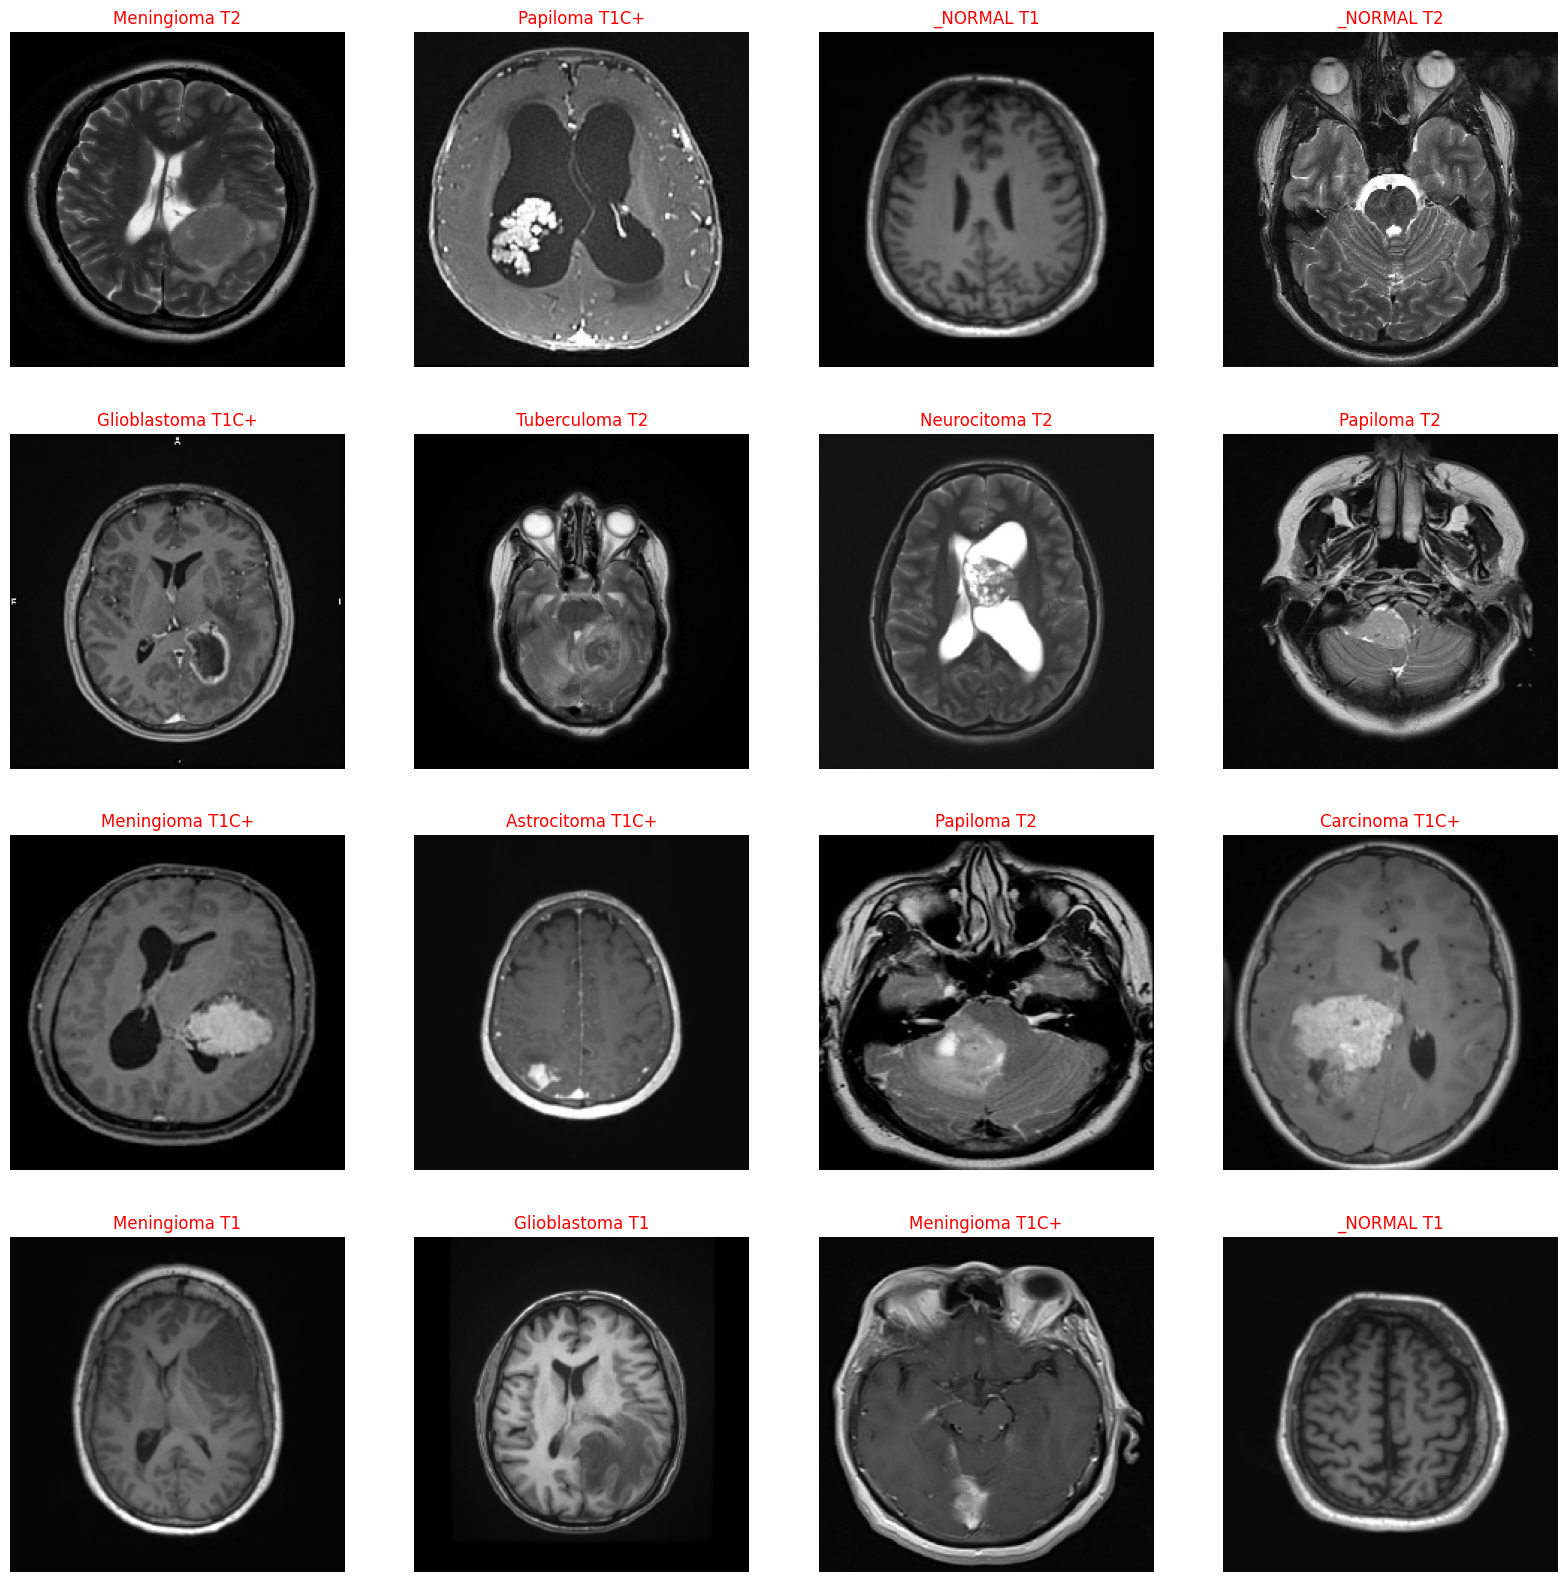

In [16]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

In [17]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [27]:
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_shape[0], image_shape[1], channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),         #helps in stabilizing and accelerating the learning process, axis=-1 => normalisation on the feature axis;It means that for each feature, the mean and standard deviation will be computed independently.
                                                                          #momentum: 99% of the previous statistics will be retained. Usually done for stablisation
                                                                          #epsilon: avoid division by zero in the normalisation process[esp if the variance is very small]
    Dense(
    256,
    bias_regularizer=regularizers.l1(0.006),
    activation='relu'
),
Dropout(rate=0.45),
Dense(class_count, activation='softmax')])

model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),])

model.summary()




#activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18432)               │          73,728 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 44)                  │          11,308 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,044,716 (19.24 MB)

 Trainable params: 5,007,852 (19.10 MB)

 Non-trainable params: 36,864 (144.00 KB)

In [28]:
hist= model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.2003 - loss: 3.5747 - precision_2: 0.4522 - recall_2: 0.0860 - val_accuracy: 0.4497 - val_loss: 2.0823 - val_precision_2: 0.6850 - val_recall_2: 0.3065
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.5158 - loss: 1.8710 - precision_2: 0.7939 - recall_2: 0.3177 - val_accuracy: 0.6376 - val_loss: 1.3830 - val_precision_2: 0.8088 - val_recall_2: 0.4541
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.6446 - loss: 1.3585 - precision_2: 0.8519 - recall_2: 0.4579 - val_accuracy: 0.7338 - val_loss: 1.0635 - val_precision_2: 0.8982 - val_recall_2: 0.5727
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.7321 - loss: 1.0272 - precision_2: 0.8971 - recall_2: 0.5533 - val_accuracy: 0.7584 - val_loss: 1.0049 - val_precision_2: 0.8949 - val_recall_2: 0.5906
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.7811 - loss: 0.8377 - precision_2: 0.9205 - rec

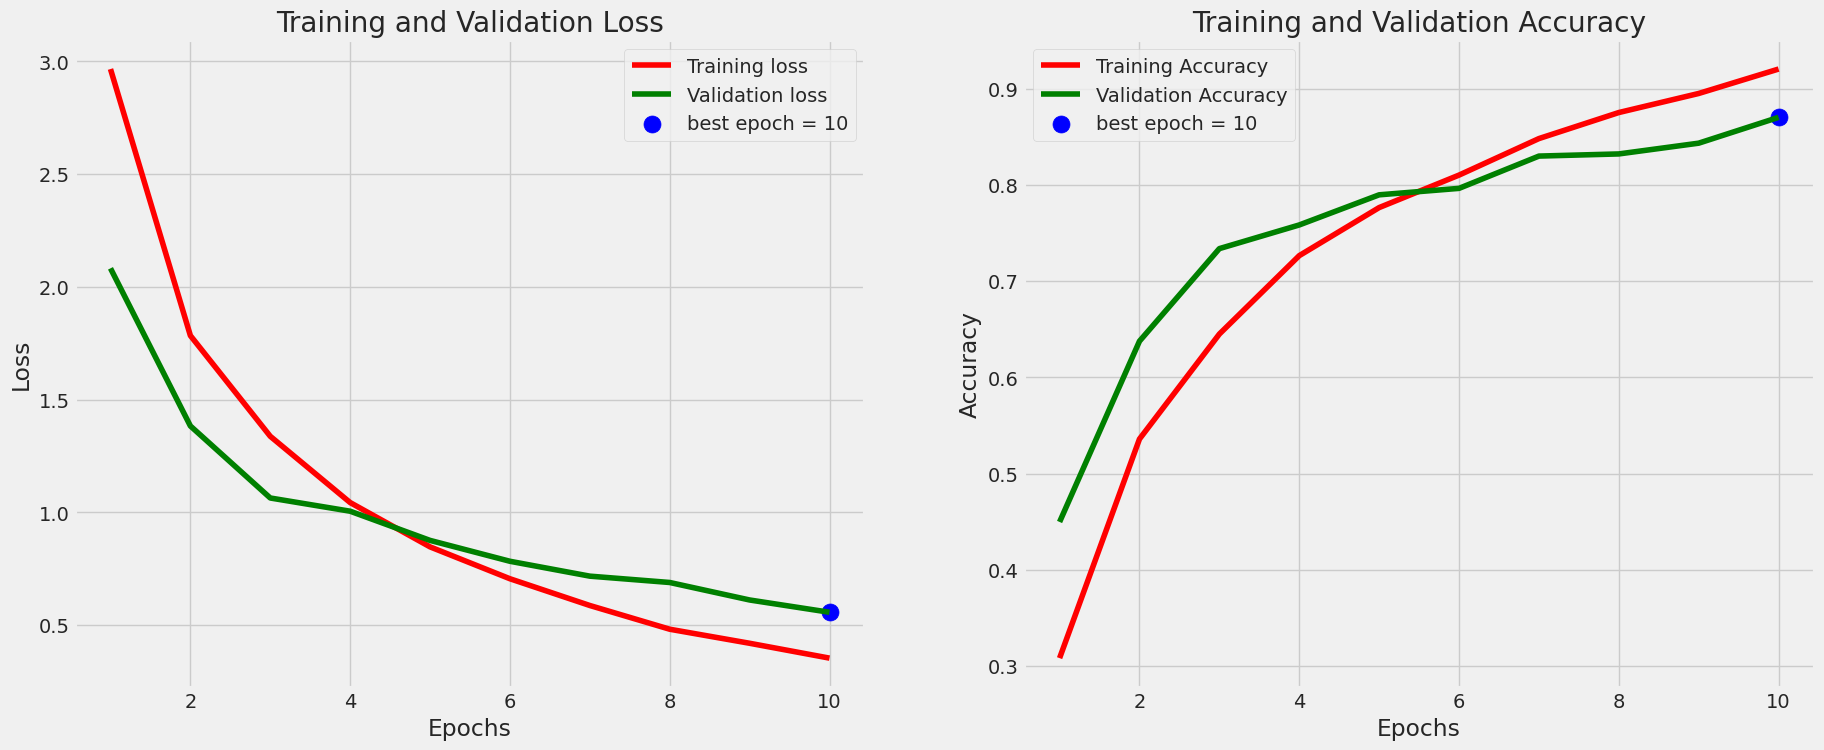

In [29]:

tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [30]:
train_score= model.evaluate(train_gen)
valid_score= model.evaluate(valid_gen)
test_score=  model.evaluate(test_gen)


112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.9897 - loss: 0.1085 - precision_2: 0.9956 - recall_2: 0.9689
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8756 - loss: 0.5238 - precision_2: 0.9445 - recall_2: 0.7929
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9026 - loss: 0.4273 - precision_2: 0.9542 - recall_2: 0.8204


In [31]:


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('=' * 20)
print( )
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('=' * 20)
print( )
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])



Train Loss:  0.10673542320728302
Train Accuracy:  0.9907898306846619

Valid Loss:  0.5566130876541138
Valid Accuracy:  0.8702461123466492

Test Loss:  0.5200100541114807
Test Accuracy:  0.8816964030265808
